Features: 4
Outputs: 3
Using cpu
X_train shape: torch.Size([120, 4])
X_test shape: torch.Size([30, 4])
y_train shape: torch.Size([120])
Scaled value X_train[0]:tensor([0.0882, 0.6667, 0.0000, 0.0417])
Early stopping at epoch 51
Final Accuracy: 96.67%
Confusion Matrix:
[[10  0  0]
 [ 0  8  1]
 [ 0  0 11]]


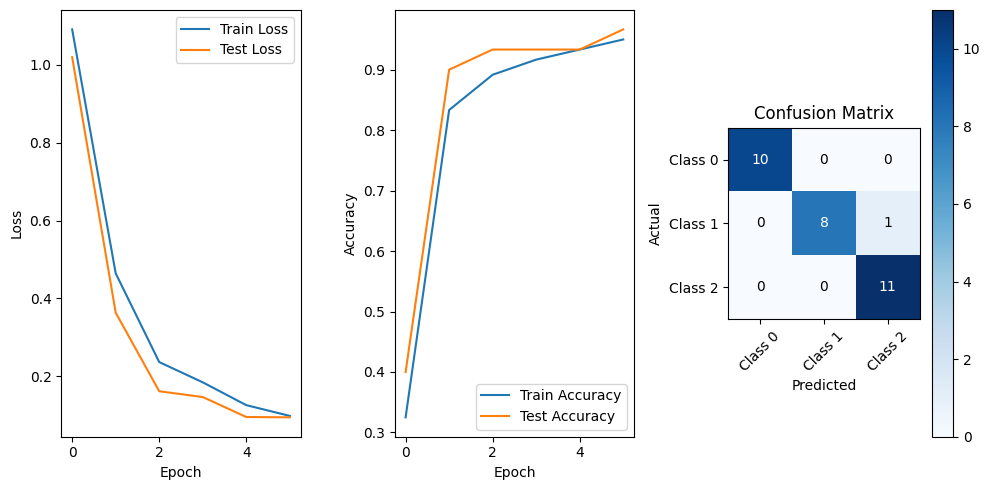

In [11]:
import torch
import torch.nn as nn
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

iris = load_iris()
X = iris.data
y = iris.target

EPOCH = 100
PRINT_EVERY = EPOCH // 10
LR = 1e-2
HIDDEN_LAYER = 64
FEATURES = X.shape[1]
OUTPUTS = len(set(y))
print(f"Features: {FEATURES}")
print(f"Outputs: {OUTPUTS}")

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# do min max scale so values are 0-1
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

device = "cudo" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")
# to tensor
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"Scaled value X_train[0]:{X_train[0]}")


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = NeuralNet(FEATURES, HIDDEN_LAYER, OUTPUTS).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# -- early stopping : es-> early stopping predix
best_loss_es = float('inf')
wait_es = 0
best_weights_es = None
patience_es = 5

# training
train_loss, test_loss = [], []
train_acc, test_acc = [], []
for epoch in range(EPOCH):
    # train
    model.train()
    logits = model(X_train)
    loss = loss_fn(logits, y_train)
    y_pred = torch.argmax(logits, dim=1)
    acc = accuracy_score(y_train.cpu().numpy(), y_pred.cpu().numpy())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # testing
    model.eval()
    with torch.no_grad():
        t_logits = model(X_test)
        t_loss = loss_fn(t_logits, y_test)
        t_y_pred = torch.argmax(t_logits, dim=1)
        t_acc = accuracy_score(y_test.cpu().numpy(), t_y_pred.cpu().numpy())

        if epoch % PRINT_EVERY == 0:
          train_loss.append(loss.item())
          train_acc.append(acc)
          test_loss.append(t_loss.item())
          test_acc.append(t_acc)


    # Early stopping check
    if t_loss < best_loss_es:
      best_loss_es = t_loss
      wait = 0
      best_weights = model.state_dict().copy()
    else:
      wait += 1
      if wait >= patience_es:
        print(f"Early stopping at epoch {epoch}")
        break

# Load best weights - part of early stopping
model.load_state_dict(best_weights)

model.eval()
with torch.inference_mode():
    te_logits = model(X_test)
    te_probs = torch.softmax(te_logits, dim=1)
    te_pred = te_logits.argmax(1).cpu().numpy()

acc = accuracy_score(y_test, te_pred)
cm  = confusion_matrix(y_test, te_pred)
print(f"Final Accuracy: {100*acc:.2f}%")
print(f"Confusion Matrix:\n{cm}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


# Confusion matrix heatmap
plt.subplot(1, 3, 3)
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
ticks = np.arange(OUTPUTS)
plt.xticks(ticks, [f'Class {i}' for i in range(OUTPUTS)], rotation=45)
plt.yticks(ticks, [f'Class {i}' for i in range(OUTPUTS)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
for i in range(OUTPUTS):
    for j in range(OUTPUTS):
        plt.text(j, i, cm[i, j], ha='center', va='center',
                color='white' if cm[i, j] > cm.max()/2 else 'black')

plt.tight_layout()
plt.show()

